<a href="https://colab.research.google.com/github/SofiNurul/SKRIPSI/blob/main/Salinan_dari_Prediksi_Sentiment_Analisis_Produk_Penghilang_Bekas_Luka_di_Shopee_Dengan_Algoritma_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY DAN DATASET**

---




In [1]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from wordcloud import WordCloud
import joblib

Mengunduh resource nltk yang diperlukan

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Muat dataset

In [3]:
df = pd.read_csv('dataulasan_produk.csv', encoding='MacRoman')
df.head(10)

,no,username,date,content,texture,effectiveness,absorption capacity,score,sentiment
0,1,z*****e,10/10/2024,Pertama kali coba karena baca ulasan di Quora ...,cream gel,baru pertama x coba Guys mudah2an manjur,pas,4,positif
1,2,dindardew,03/09/2024,Penasaran bgt dari dulu udah laser jg bekas lu...,lembut dan dingin ke kulit,belum tau baru d pakai sehari,cepet,5,netral
2,3,dikamungil,03/09/2024,"Udah ku pke beberapa kali sih, semoga bermanfa...",gel,baik,cepat,5,positif
3,4,cakranouval,11/08/2024,"kecewa, kemasan penyok",gel lembut,efektif,cepat,3,negatif
4,5,ilhamansyari22,18/06/2024,Barang sesuai pesanan ‚ò∫Ô∏è,gel lembut,efektif,cepat,5,netral
5,6,inggihsatrianisatriani,18/06/2024,Baru pertama kali coba mudah mudahan bisa puda...,baik,blom tau baru coba,bagus,5,positif
6,7,m*****4,06/06/2024,"Baru mau nyoba, semoga manjur menghilangkan be...",gel,bagus,bagus,5,positif
7,8,nonaa2,02/06/2024,"Cottonbud gak dikasih, pelit banget, gimana pa...",gel,bagus,baik,3,negatif
8,9,linarifqun,12/05/2024,Alhamdulillah Paketku sudah sampai pesanannya ...,gel,bagus,bagus,3,positif
9,10,v*****8,11/05/2024,"Dikasih thr sama kakaknya, MasyaAllah berkah s...",gel kental,semoga bekerja dengan baik,belum tau,5,positif


# **DATA SELECTION**

---



Melakukan data selection

In [4]:
# Memilih kolom yang relevan
df_selected = df[['username', 'content', 'sentiment']]
# Menghapus baris yang memiliki nilai kosong pada kolom 'content'
df_selected.dropna(subset=['content'], inplace=True)
# Menampilkan 10 baris pertama dari data yang telah diseleksi
df_selected.head(10)

<ipython-input-4-140f985cd337>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(subset=['content'], inplace=True)


,username,content,sentiment
0,z*****e,Pertama kali coba karena baca ulasan di Quora ...,positif
1,dindardew,Penasaran bgt dari dulu udah laser jg bekas lu...,netral
2,dikamungil,"Udah ku pke beberapa kali sih, semoga bermanfa...",positif
3,cakranouval,"kecewa, kemasan penyok",negatif
4,ilhamansyari22,Barang sesuai pesanan ‚ò∫Ô∏è,netral
5,inggihsatrianisatriani,Baru pertama kali coba mudah mudahan bisa puda...,positif
6,m*****4,"Baru mau nyoba, semoga manjur menghilangkan be...",positif
7,nonaa2,"Cottonbud gak dikasih, pelit banget, gimana pa...",negatif
8,linarifqun,Alhamdulillah Paketku sudah sampai pesanannya ...,positif
9,v*****8,"Dikasih thr sama kakaknya, MasyaAllah berkah s...",positif


# **DATA PREPROCESSING**

---



Daftar stopwords dari NLTK dan tambahan khusus Bahasa Indonesia

In [5]:
stopwords_tambahan = list([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin'
])

Inisialisasi Stemmer dari Sastrawi

In [6]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.5 MB/s eta 0:00:00


Pembersihan teks

In [7]:
def clean_text(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)  # Menghapus URL
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)  # Menghilangkan karakter non-ASCII
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    teks = re.sub(r'\d+', '', teks)  # Menghapus angka
    return teks

Fungsi untuk tokenisasi

In [8]:
def tokenize(teks):
    return teks.split()

Fungsi untuk stemming

In [9]:
def apply_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

Terapkan pra-pemrosesan ke data

In [10]:
df_selected['cleaned_content'] = df_selected['content'].apply(clean_text)

<ipython-input-10-e0c27e1bd33e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['cleaned_content'] = df_selected['content'].apply(clean_text)


Menampilkan hasil tokenisasi dan stemming untuk 5 sampel teratas

In [11]:
print("\n=== Hasil Tokenisasi dan Stemming untuk 5 Sampel Teratas ===")
for i in range(5):  # Menampilkan 5 contoh pertama
    original_text = df_selected.iloc[i]['content']
    cleaned_text = df_selected.iloc[i]['cleaned_content']
    tokens = tokenize(cleaned_text)
    stemmed_tokens = apply_stemming(tokens)

    print(f"Contoh {i+1}:")
    print("Teks Asli:", original_text)
    print("Setelah Pembersihan:", cleaned_text)
    print("Setelah Tokenisasi:", tokens)
    print("Setelah Stemming:", stemmed_tokens)
    print("-" * 50)


=== Hasil Tokenisasi dan Stemming untuk 5 Sampel Teratas ===
Contoh 1:
Teks Asli: Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas hamil anak ke 2 memudar, hasilnya pemakaian 1 botol insyaallah akan aku update ya.. kalo emang bagus pasti repurchase (beli lagi) di toko ini, Sellernya ramah dan amanah.. suka kalo di chat gercep di balas gak pake lama, pengiriman ke Jakarta juga cepat.i
Setelah Pembersihan: pertama kali coba karena baca ulasan di quora katanya bagus semoga ngefek bekas korengan pas hamil anak ke  memudar hasilnya pemakaian  botol insyaallah akan aku update ya kalo emang bagus pasti repurchase beli lagi di toko ini sellernya ramah dan amanah suka kalo di chat gercep di balas gak pake lama pengiriman ke jakarta juga cepati
Setelah Tokenisasi: ['pertama', 'kali', 'coba', 'karena', 'baca', 'ulasan', 'di', 'quora', 'katanya', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'ke', 'memudar', 'hasilnya', 'pe

Pisahkan data berlabel dan tak berlabel

In [12]:
df_labeled = df_selected[df_selected['sentiment'].notna()]
df_unlabeled = df_selected[df_selected['sentiment'].isna()]

# **DATA TRANSFORMASI**

---



Vektorisasi menggunakan TF-IDF dengan unigram, bigram, dan trigram

In [13]:
all_cleaned_content = pd.concat([df_labeled['cleaned_content'], df_unlabeled['cleaned_content']])
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.75, min_df=3, stop_words=stopwords_tambahan, max_features=5000)
all_features = vectorizer.fit_transform(all_cleaned_content)

Pisahkan fitur untuk data berlabel dan tak berlabel

In [14]:
X_labeled = all_features[:len(df_labeled)]
X_unlabeled = all_features[len(df_labeled):]
y_labeled = df_labeled['sentiment']

10 sampel komentar acak dari kolom 'content' untuk analisis TF-IDF

In [15]:
sample_content = df['content'].sample(10, random_state=1).tolist() # Ambil 10 sampel komentar acak dari kolom 'content' untuk analisis TF-IDF
# Terapkan vektorisasi TF-IDF pada sampel komentar yang telah diambil
vectorizer = TfidfVectorizer()
X_sample = vectorizer.fit_transform(sample_content)
# Ubah hasil TF-IDF menjadi DataFrame agar lebih mudah dibaca
feature_names = vectorizer.get_feature_names_out()
tfidf_sample_df = pd.DataFrame(X_sample.toarray(), columns=feature_names)
# Tampilkan nilai TF-IDF untuk sampel komentar yang diambil
tfidf_sample_df.head()


,2x,3x,ada,aja,alhamdulillah,amanah,ampuh,anti,awalnya,banget,...,uda,untuk,ya,yang,yg,you,üëç,üòå,üòç,üôè
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.159452,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.159903,0.000000,0.000000,0.000000,...,0.0,0.188101,0.0,0.000000,0.279792,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.150801,0.150801,0.150801,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.512778,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.153389,0.000000,0.180439,0.153389,...,0.0,0.000000,0.0,0.153389,0.000000,0.0,0.0,0.180439,0.541316,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.220124,0.000000,0.220124,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.220124


# **DATA MINING (Model : Naive Bayes)**

---



Mendapatkan daftar kelas unik dari data berlabel (y_labeled)

In [39]:
classes = sorted(y_labeled.unique())

Membagi data berlabel menjadi data latih dan data uji

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.1, random_state=42)

Latih model Naive Bayes pada data latih

In [41]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

Evaluasi model pada data uji

In [42]:
y_pred_val = model.predict(X_val)
print("=== Laporan Klasifikasi pada Data Uji ===")
print(classification_report(y_val, y_pred_val))
print("Akurasi pada data uji:", accuracy_score(y_val, y_pred_val))

=== Laporan Klasifikasi pada Data Uji ===
              precision    recall  f1-score   support

     negatif       1.00      0.57      0.73        14
      netral       0.92      0.55      0.69        22
     positif       0.68      0.97      0.80        35

    accuracy                           0.76        71
   macro avg       0.87      0.70      0.74        71
weighted avg       0.82      0.76      0.75        71

Akurasi pada data uji: 0.7605633802816901


Membuat Confusion Matrix untuk data uji

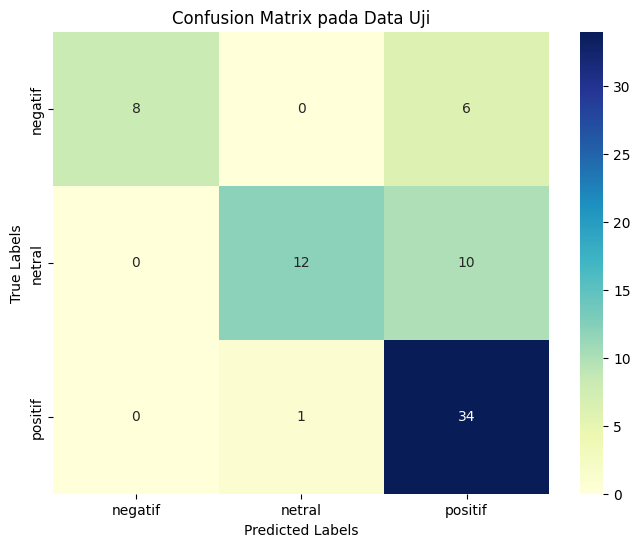

In [43]:
conf_matrix_val = confusion_matrix(y_val, y_pred_val, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix pada Data Uji")
plt.show()

Mendapatkan nilai True Positive (TP), False Positive (FP), False Negative (FN), dan True Neutral (TNt) untuk setiap kelas

In [44]:
TP = np.diag(conf_matrix_val)  # True Positives untuk setiap kelas
FP = np.sum(conf_matrix_val, axis=0) - TP  # False Positives untuk setiap kelas
FN = np.sum(conf_matrix_val, axis=1) - TP  # False Negatives untuk setiap kelas
TN = np.sum(conf_matrix_val) - (FP + FN + TP)  # True Negatives untuk setiap kelas

# Mendefinisikan True Neutral (TNt) dan False Neutral (FNt) untuk kelas "netral"
netral_index = classes.index("netral")
TNt = TP[netral_index]  # True Neutral untuk kelas netral
FNt = FN[netral_index]  # False Neutral untuk kelas netral

Menghitung Akurasi

In [45]:
total_correct = np.sum(TP)  # Semua prediksi benar (ΣTP)
total_data = np.sum(conf_matrix_val)  # Total seluruh data
accuracy = total_correct / total_data * 100

print("Akurasi = (ΣTP) / Total x 100")
print(f"= ({np.sum(TP)}) / {total_data} x 100")
print(f"= {accuracy:.2f}%\n")

Akurasi = (ΣTP) / Total x 100
= (54) / 71 x 100
= 76.06%



Menghitung Precision, Recall, dan F1-Score untuk setiap kelas

In [46]:
precision = TP / (TP + FP) * 100  # Persen
recall = TP / (TP + FN) * 100     # Persen
f1_score = 2 * (precision * recall) / (precision + recall)
results = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

print("\n=== Perhitungan Presisi, Recall, dan F1-Score untuk setiap Kelas ===")
for idx, row in results.iterrows():
    print(f"\nKelas {row['Class']}:")
    print(f"Presisi = TP / (TP + FP)")
    print(f"= {TP[idx]} / ({TP[idx]} + {FP[idx]}) x 100")
    print(f"= {row['Precision']:.2f}%")

    print(f"Recall = TP / (TP + FN)")
    print(f"= {TP[idx]} / ({TP[idx]} + {FN[idx]}) x 100")
    print(f"= {row['Recall']:.2f}%")

    print(f"F1-Score = 2 * (Precision * Recall) / (Precision + Recall)")
    print(f"= 2 * ({row['Precision']:.2f}% * {row['Recall']:.2f}%) / ({row['Precision']:.2f}% + {row['Recall']:.2f}%)")
    print(f"= {row['F1-Score']:.2f}%")



=== Perhitungan Presisi, Recall, dan F1-Score untuk setiap Kelas ===

Kelas negatif:
Presisi = TP / (TP + FP)
= 8 / (8 + 0) x 100
= 100.00%
Recall = TP / (TP + FN)
= 8 / (8 + 6) x 100
= 57.14%
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
= 2 * (100.00% * 57.14%) / (100.00% + 57.14%)
= 72.73%

Kelas netral:
Presisi = TP / (TP + FP)
= 12 / (12 + 1) x 100
= 92.31%
Recall = TP / (TP + FN)
= 12 / (12 + 10) x 100
= 54.55%
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
= 2 * (92.31% * 54.55%) / (92.31% + 54.55%)
= 68.57%

Kelas positif:
Presisi = TP / (TP + FP)
= 34 / (34 + 16) x 100
= 68.00%
Recall = TP / (TP + FN)
= 34 / (34 + 1) x 100
= 97.14%
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
= 2 * (68.00% * 97.14%) / (68.00% + 97.14%)
= 80.00%


Menghitung rata-rata untuk Presisi, Recall, dan F1-Score

In [47]:
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print("\n=== Rata-rata Presisi, Recall, dan F1-Score ===")
print(f"Rata-rata Presisi = ΣPresisi / Jumlah Kelas")
print("= " + " + ".join([f"{p:.2f}%" for p in precision]) + f" / {len(classes)}")
print(f"= {avg_precision:.2f}%\n")

print("Rata-rata Recall = ΣRecall / Jumlah Kelas")
print("= " + " + ".join([f"{r:.2f}%" for r in recall]) + f" / {len(classes)}")
print(f"= {avg_recall:.2f}%\n")

print("Rata-rata F1-Score = ΣF1-Score / Jumlah Kelas")
print("= " + " + ".join([f"{f:.2f}%" for f in f1_score]) + f" / {len(classes)}")
print(f"= {avg_f1_score:.2f}%\n")


=== Rata-rata Presisi, Recall, dan F1-Score ===
Rata-rata Presisi = ΣPresisi / Jumlah Kelas
= 100.00% + 92.31% + 68.00% / 3
= 86.77%

Rata-rata Recall = ΣRecall / Jumlah Kelas
= 57.14% + 54.55% + 97.14% / 3
= 69.61%

Rata-rata F1-Score = ΣF1-Score / Jumlah Kelas
= 72.73% + 68.57% + 80.00% / 3
= 73.77%



Memprediksi sentimen untuk data yang belum berlabel

In [48]:
predicted_sentiment = model.predict(X_unlabeled)
df_unlabeled.loc[:, 'sentiment'] = predicted_sentiment

Gabungkan hasil prediksi ke dalam dataset asli

In [49]:
df_selected.update(df_unlabeled[['sentiment', 'cleaned_content']])

Verifikasi kolom 'cleaned_content' dan 'sentiment'

In [50]:
print("Verifikasi 'cleaned_content' dan 'sentiment' di df_selected:")
print(df_selected[['content', 'cleaned_content', 'sentiment']].head())

Verifikasi 'cleaned_content' dan 'sentiment' di df_selected:
                                             content  \
0  Pertama kali coba karena baca ulasan di Quora ...   
1  Penasaran bgt dari dulu udah laser jg bekas lu...   
2  Udah ku pke beberapa kali sih, semoga bermanfa...   
3                             kecewa, kemasan penyok   
4                       Barang sesuai pesanan ‚ò∫Ô∏è   

                                     cleaned_content sentiment  
0  pertama kali coba karena baca ulasan di quora ...   positif  
1  penasaran bgt dari dulu udah laser jg bekas lu...    netral  
2  udah ku pke beberapa kali sih semoga bermanfaa...   positif  
3                              kecewa kemasan penyok   negatif  
4                            barang sesuai pesanan      netral  


Simpan hasil prediksi ke file CSV

In [51]:
df_selected.to_csv('final_hasil_prediksi_sentimen_naivebayes.csv', index=False)
print("Hasil prediksi sentimen telah disimpan dalam file 'final_hasil_prediksi_sentimen_naivebayes.csv'.")

Hasil prediksi sentimen telah disimpan dalam file 'final_hasil_prediksi_sentimen_naivebayes.csv'.


Membuat kolom untuk perbandingan sentimen manual dan prediksi

In [57]:
df_comparison = df_selected[['content', 'sentiment']].copy()
df_comparison['sentiment_prediksi'] = model.predict(all_features)

Menampilkan data yang diberi label manual dan data prediksi Naive Bayes

In [58]:
df_comparison_labeled = df_comparison[df_selected['sentiment'].notna()]  # Data berlabel manual
df_comparison_prediksi = df_comparison[df_selected['sentiment'].isna()]  # Data hasil prediksi
print("=== Data yang Diberi Label Manual ===")
print(df_comparison_labeled.head(10))  # Menampilkan 10 baris pertama data manual

print("\n=== Data Prediksi Naive Bayes ===")
print(df_comparison_prediksi.head(10))  # Menampilkan 10 baris pertama data prediksi

=== Data yang Diberi Label Manual ===
                                             content sentiment  \
0  Pertama kali coba karena baca ulasan di Quora ...   positif   
1  Penasaran bgt dari dulu udah laser jg bekas lu...    netral   
2  Udah ku pke beberapa kali sih, semoga bermanfa...   positif   
3                             kecewa, kemasan penyok   negatif   
4                       Barang sesuai pesanan ‚ò∫Ô∏è    netral   
5  Baru pertama kali coba mudah mudahan bisa puda...   positif   
6  Baru mau nyoba, semoga manjur menghilangkan be...   positif   
7  Cottonbud gak dikasih, pelit banget, gimana pa...   negatif   
8  Alhamdulillah Paketku sudah sampai pesanannya ...   positif   
9  Dikasih thr sama kakaknya, MasyaAllah berkah s...   positif   

  sentiment_prediksi  
0            positif  
1            positif  
2            positif  
3            negatif  
4             netral  
5             netral  
6            positif  
7            positif  
8            positif  
9    

Simpan perbandingan ke dalam file CSV

In [54]:
df_comparison.to_csv('perbandingan_sentimen_asli_dan_prediksi.csv', index=False)
print("Perbandingan sentimen asli dan prediksi telah disimpan dalam file 'perbandingan_sentimen_asli_dan_prediksi.csv'.")

Perbandingan sentimen asli dan prediksi telah disimpan dalam file 'perbandingan_sentimen_asli_dan_prediksi.csv'.


# **Visualisasi hasil evaluasi**

---



Distribusi Sentimen Bar Chart

<ipython-input-36-a2e1a35135bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['sentiment'] = predicted_sentiment  # Prediksi sentimen untuk data tanpa label
<ipython-input-36-a2e1a35135bf>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#66c2a5', '#fc8d62', '#8da0cb'])


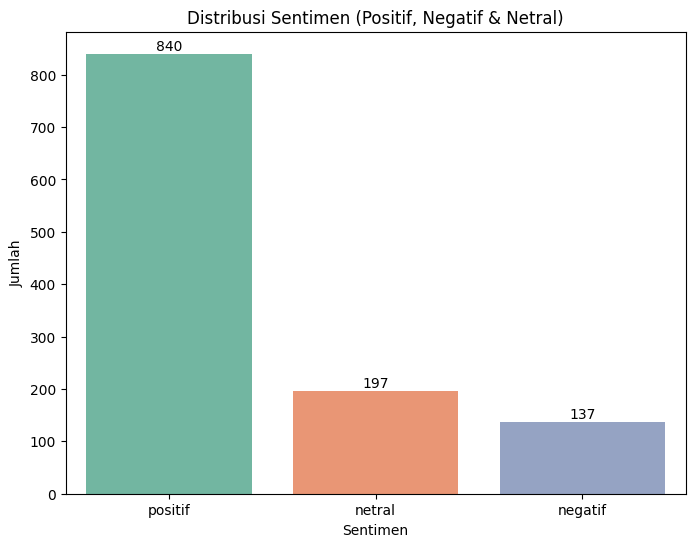

In [36]:
# Update kolom 'sentiment' di dataframe asli
df_unlabeled['sentiment'] = predicted_sentiment  # Prediksi sentimen untuk data tanpa label
df.update(df_unlabeled[['sentiment']])

# Hitung ulang distribusi sentimen
sentiment_counts = df['sentiment'].value_counts()

# Plot Distribusi Sentimen Bar Chart dengan warna khusus
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Distribusi Sentimen (Positif, Negatif & Netral)')

# Menampilkan jumlah di atas setiap bar
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 1, str(value), ha='center', va='bottom')

plt.show()


Distribusi Sentimen Pie Chart

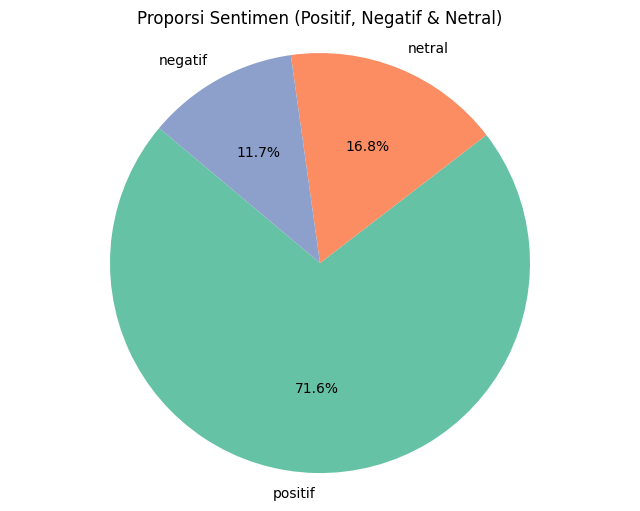

In [37]:
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.axis('equal')
plt.title('Proporsi Sentimen (Positif, Negatif & Netral)')
plt.show()

Wordcloud untuk ulasan Positif, Negatif dan Netral

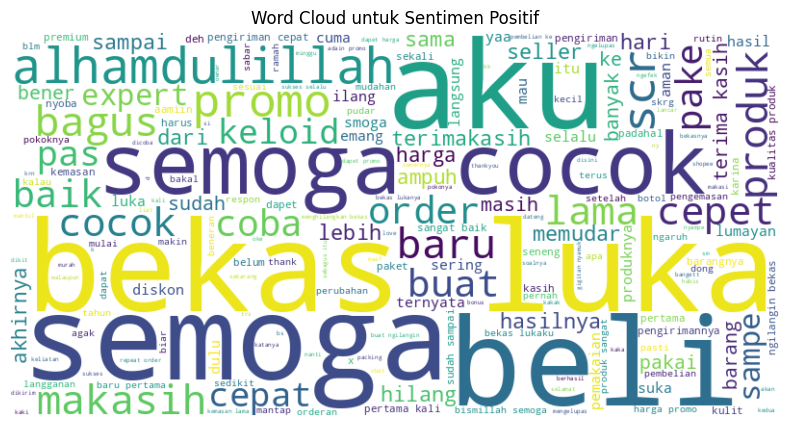

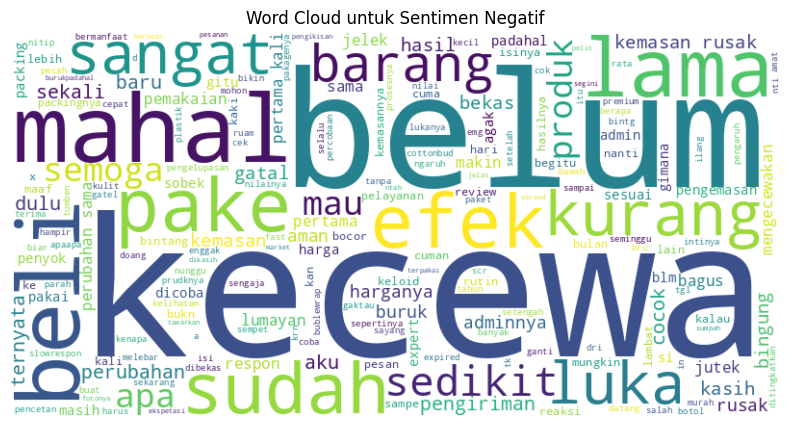

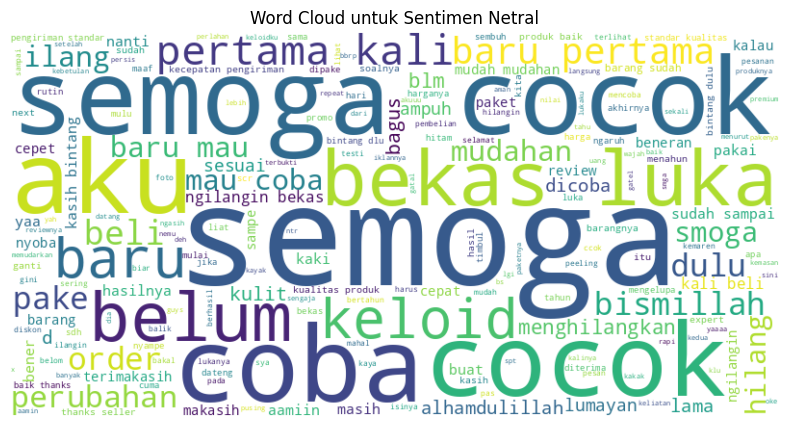

In [38]:
def generate_wordcloud(df, sentiment_label, title):
    # Verifikasi apakah ada data untuk sentimen yang diberikan
    if sentiment_label not in df['sentiment'].unique():
        print(f"Tidak ada data untuk sentimen: {sentiment_label}")
        return
    # Gabungkan teks untuk Word Cloud
    text = ' '.join(df[df['sentiment'] == sentiment_label]['cleaned_content'].fillna(''))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_tambahan).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Tampilkan Word Cloud untuk setiap sentimen
generate_wordcloud(df_selected, 'positif', 'Word Cloud untuk Sentimen Positif')
generate_wordcloud(df_selected, 'negatif', 'Word Cloud untuk Sentimen Negatif')
generate_wordcloud(df_selected, 'netral', 'Word Cloud untuk Sentimen Netral')